In [ ]:
"""
Team Gopher Knowledge:
    Michael Ramsey, University of Colorado
    Hua Chen, University of Delaware
    Aaron Cohen, Indiana University
    Mingchang Ding, University of Delaware
    Melanie Jensen, Tulane University
    Christopher Miller, University of California, Berkeley
    
IMA Intro to Math Bootcamp: 6/1/18 - 7/20/18

Date Created: 6/1/18
Last Edited: 9/25/18

DESCRIPTION:
    This is a Python notebook to investigate the use of variational autoencoders in classifying the MNIST dataset.
    We project the orginal image space down to 50-dimensional latent space. In particular, for this file we 
    add investigate the structure of latent space.

Much of this code is adapted from: http://pyro.ai/examples/vae.html
"""

In [1]:
# Import necessary packages
import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
# Turns on model validation
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [3]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [4]:
USE_CUDA = False
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

In [5]:
"""
PyTorch module that encapsulates our decoder network. Given a latent 
code z, the forward call of Decoder returns the parameters for a 
Bernoulli distribution in image space.
"""
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc32 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden1 = self.softplus(self.fc1(z))
        #hidden2 = self.softplus(self.fc21(hidden1))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc32(hidden1))
        return loc_img

In [6]:
"""
PyTorch module that encapsulates our encoder network. Given an image x,
the forward call of Encoder returns a mean and covariance that together 
parameterize a (diagonal) Gaussian distribution in latent space.
"""
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [7]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

### Inference

In [8]:
# That’s all there is to it. Now we just have to define our training loop:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [9]:
# Evaluate the model
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

### Test The Model
Training corresponds to maximizing the evidence lower bound (ELBO) over the training 
dataset. We train for 100 iterations and evaluate the ELBO for the test dataset, see Figure 3.

In [10]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
z_dim = 20

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 50
TEST_FREQUENCY = 2

In [11]:
# setup the VAE
vae = VAE(use_cuda=USE_CUDA,z_dim=z_dim)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 186.8828
[epoch 000] average test loss: 148.2689
[epoch 001]  average training loss: 137.7810
[epoch 002]  average training loss: 125.1843
[epoch 002] average test loss: 120.4590
[epoch 003]  average training loss: 119.2938
[epoch 004]  average training loss: 115.7714
[epoch 004] average test loss: 113.6037
[epoch 005]  average training loss: 113.5988
[epoch 006]  average training loss: 112.0281
[epoch 006] average test loss: 110.5816
[epoch 007]  average training loss: 110.8471
[epoch 008]  average training loss: 109.8740
[epoch 008] average test loss: 108.6276
[epoch 009]  average training loss: 109.0306
[epoch 010]  average training loss: 108.3789
[epoch 010] average test loss: 107.3344
[epoch 011]  average training loss: 107.7874
[epoch 012]  average training loss: 107.3152
[epoch 012] average test loss: 106.3747
[epoch 013]  average training loss: 106.8902
[epoch 014]  average training loss: 106.5369
[epoch 014] average test loss: 105.7923
[epoc

### Plots and Such

In [12]:
import matplotlib.pyplot as plt

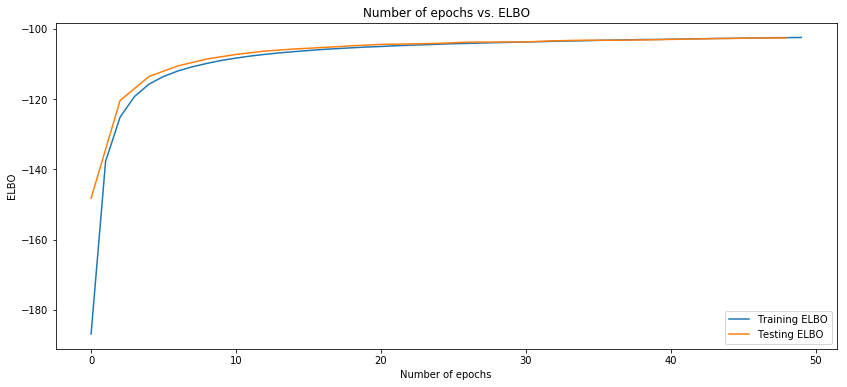

In [20]:
"Plot the results from part a"
xval1 = range(0,len(train_elbo)) # Number of training epochs
xval2 = range(0,len(train_elbo),2) # Number of testing epochs
plt.figure(figsize=(14,6)) # Control figure size
plt.plot(xval1, train_elbo,label = 'Training ELBO')
plt.plot(xval2, test_elbo ,label = 'Testing ELBO')
plt.title('Number of epochs vs. ELBO')
plt.xlabel('Number of epochs')
plt.ylabel('ELBO')
plt.legend(loc='lower right')
plt.savefig('ELBOtraining.png')

In [14]:
# Helper Function for viewing a digit
def view_digit(data_set, image_index, recon = False):
    if recon == False:
        plt.imshow(data_set.dataset[image_index][0][0,:,:], cmap = 'gray')
    else:
        b = vae.reconstruct_img(data_set.dataset[image_index][0]).detach()
        b_reshape = b[0].reshape(28,28)
        plt.imshow(b_reshape, cmap = 'gray')

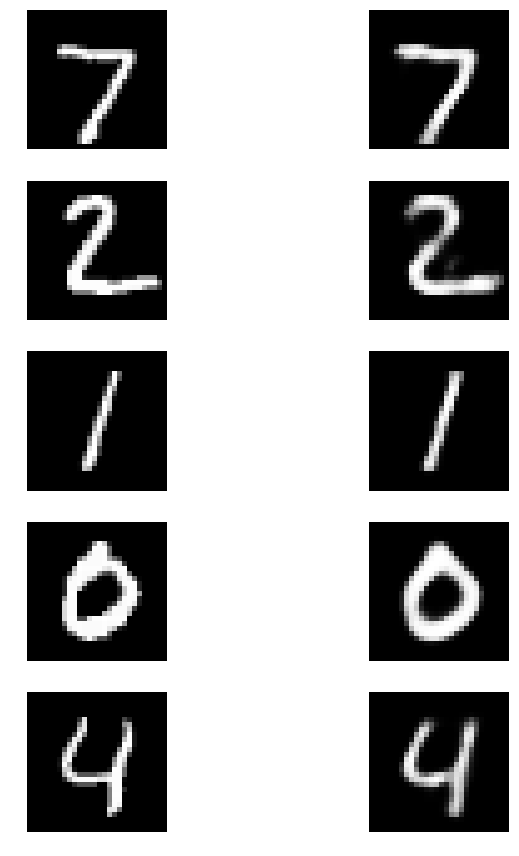

In [33]:
# Plot a few initial images and reconstructions
b=[0,0,0,0,0]                                             # Initialize array
plt.figure(figsize=(12, 12))                               # Control figure size
for i in range(5):                                        # Plot different images
    plt.subplot(5, 2, 2*i + 1)                            # Create subplots
    view_digit(test_loader, i, recon = False)  
    plt.axis('off')# View original image     
    plt.subplot(5, 2, 2*i + 2)
    view_digit(test_loader, i, recon = True)
    plt.axis('off')# View reconstructed image
plt.axis('off')
plt.tight_layout()
plt.savefig('ExampleRecon.png')

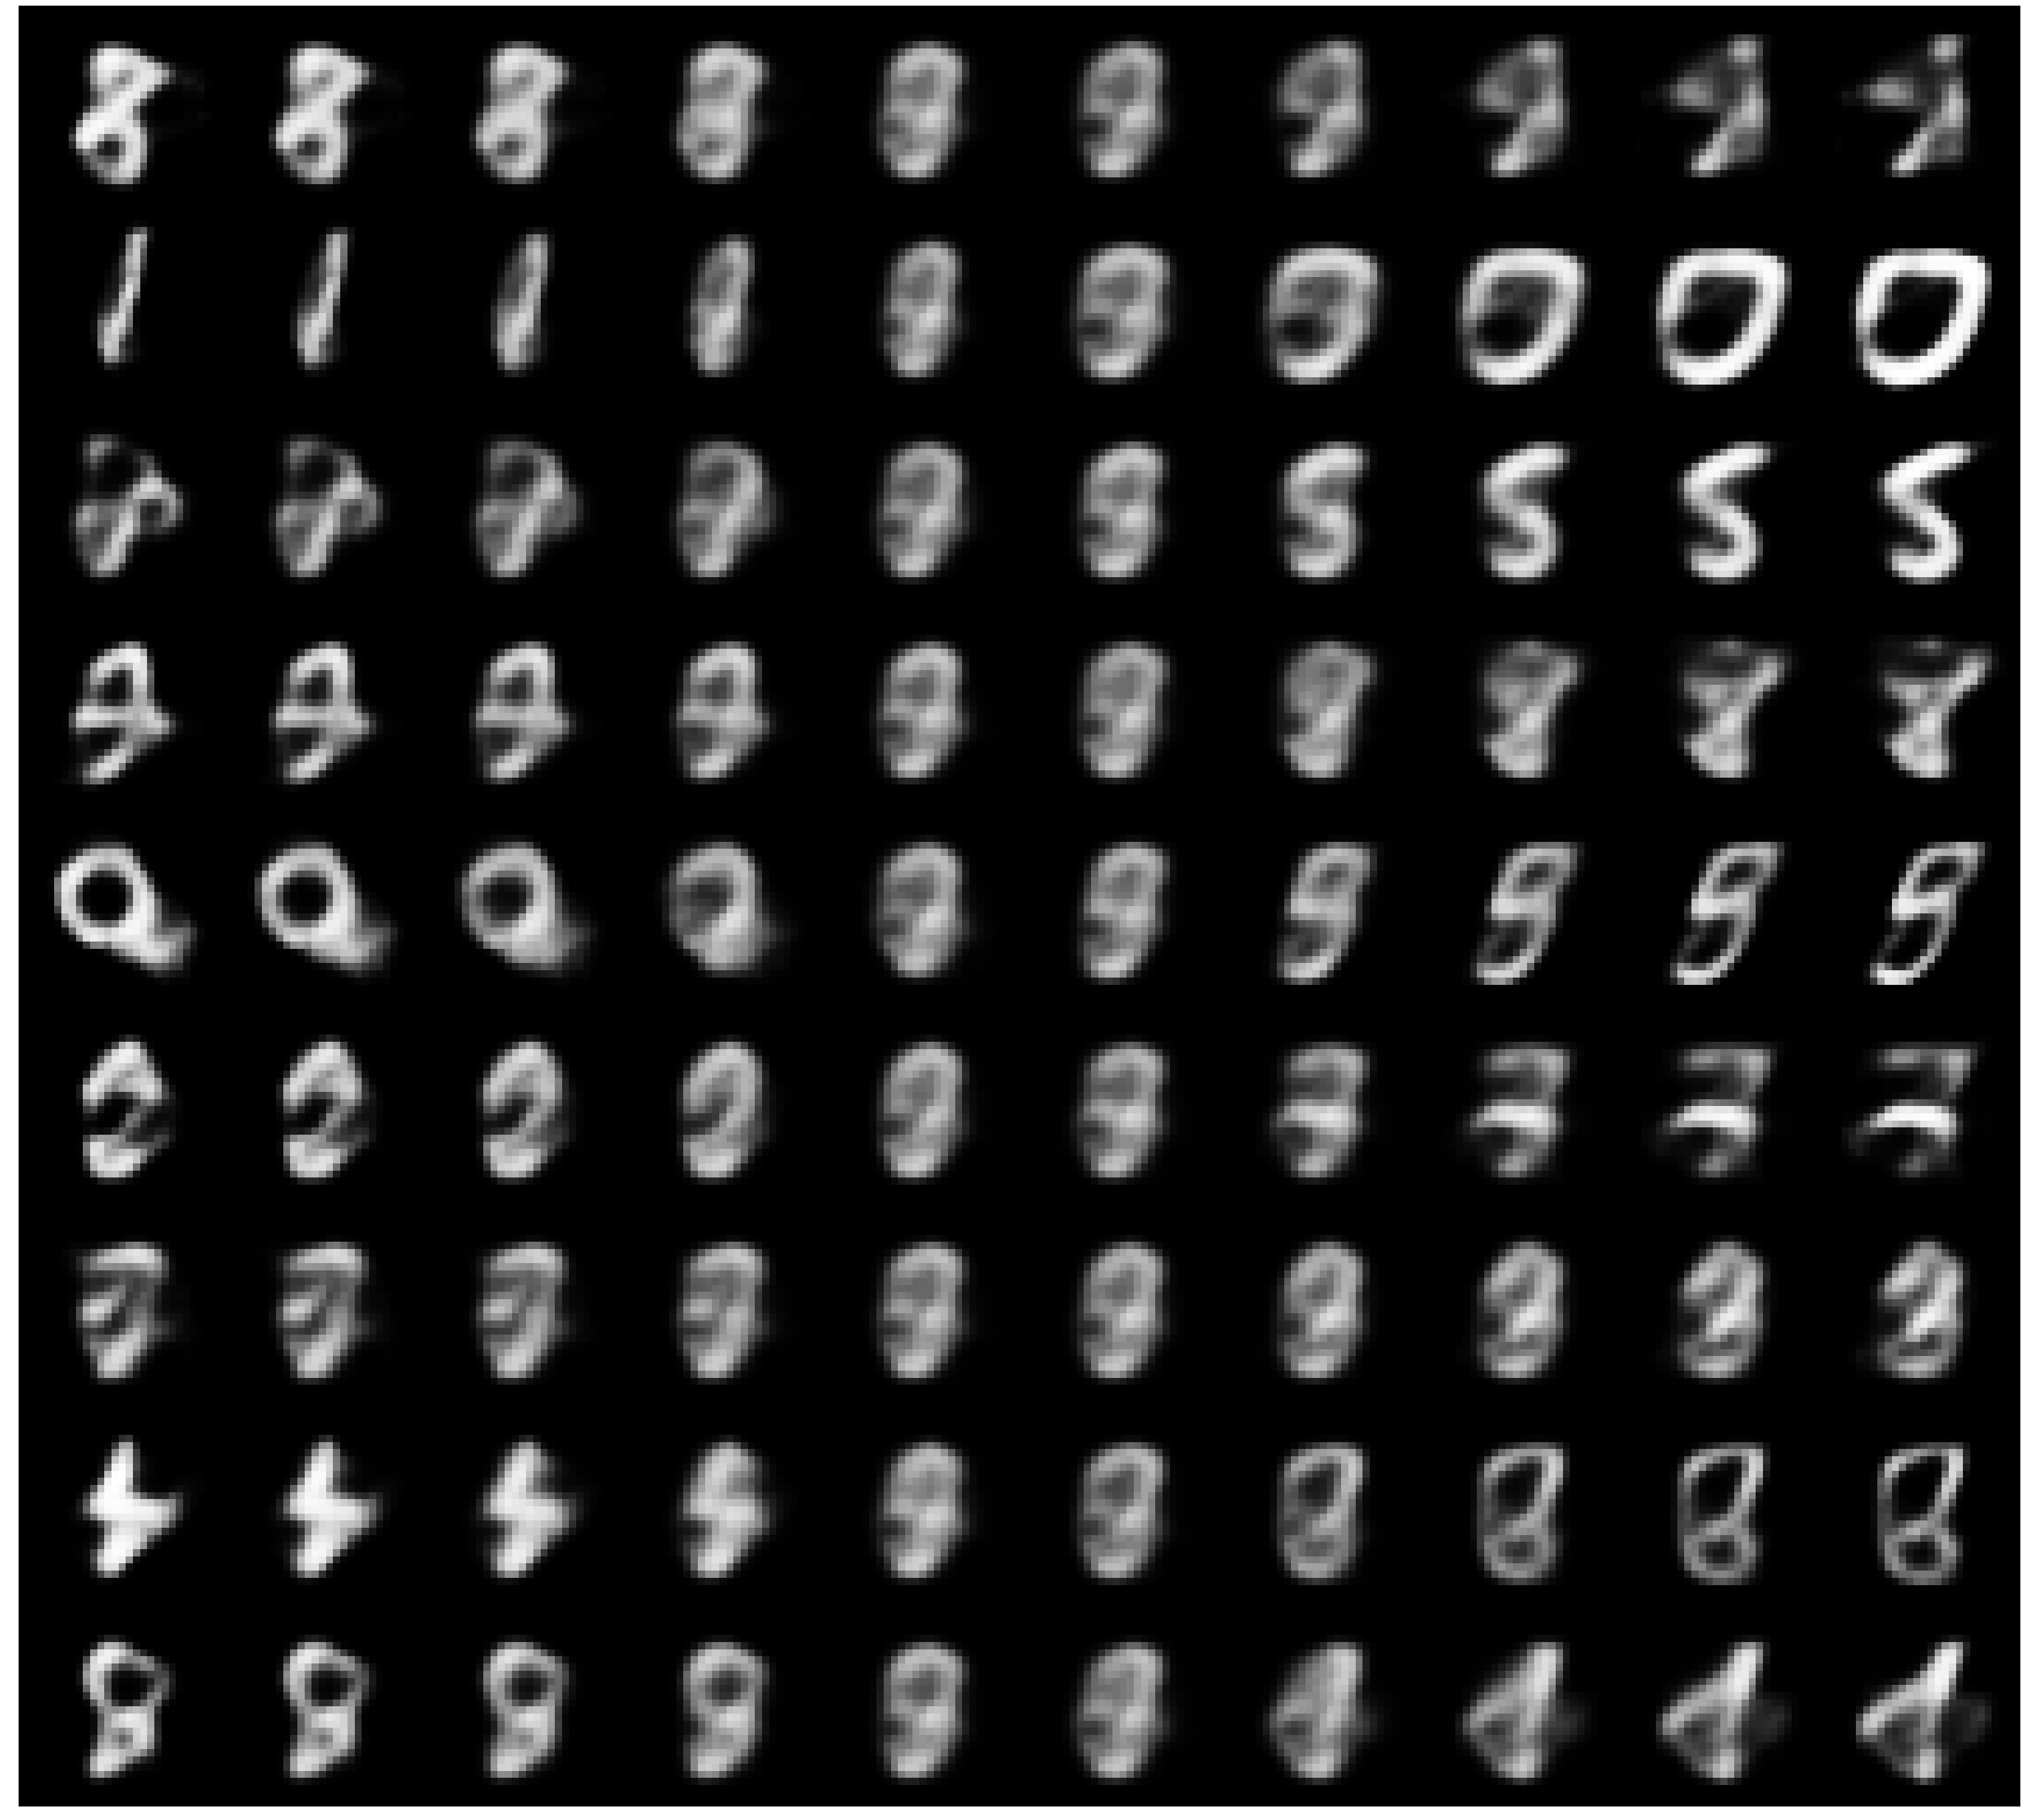

In [18]:
""" 
Here we vary one dimension of one component in latent space 
while keeping the other two fixed
"""
z_dim2 = z_dim
one_hot = np.eye(z_dim2)
nx = 10
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(1, z_dim2, 1)
canvas = np.empty((28*z_dim2, 28*nx))

fixedvar1 = 0

for j, yi in enumerate(one_hot):
    for i, xi in enumerate(x_values):
        z_loc = torch.FloatTensor([xi*yi])
        z_scale = torch.FloatTensor([[0]*z_dim2])
        z = dist.Normal(z_loc, z_scale).sample()
        x = vae.decoder.forward(z)
        canvas[j*28:(j+1)*28, i*28:(i+1)*28] = x[0].detach().reshape(28, 28)

plt.figure(figsize=(100, 45))        
Xi, Yi = np.meshgrid(x_values, y_values[0*28:9*28])
plt.imshow(canvas[:][10*28:19*28], origin="upper", cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.savefig('Change1dim20.png')